In [1]:
from jaxosqp import osqp
import jax
import jax.numpy as jnp
from jax import random

from jax.experimental import sparse

%load_ext autoreload
%autoreload 2

In [2]:
# Generate some random problem data.
B = 100
n = 25
m = 10*n

outer = lambda A: A @ A.T + 1e-2 * sparse.eye(n)
key = random.PRNGKey(208)
key, subkey = random.split(key)
P = sparse.random_bcoo(key, (B, n, n), nse=0.15, n_batch=1, generator=random.normal).todense()
P = jax.vmap(outer)(P) # Ensure P >= 0.

key, subkey = random.split(key)
q = random.normal(subkey, (B, n))
key, subkey = random.split(key)

# Add some random constraints (a la OSQP benchmarks
A = sparse.random_bcoo(subkey, (B, m, n), nse=0.15, n_batch=1, generator=random.normal).todense()
key, subkey = random.split(key)
l = -random.uniform(subkey, (B, m))
key, subkey = random.split(key)
u = random.uniform(subkey, (B, m))

In [4]:
def solve_osqp(P, q, A, l, u):
    prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
    return jax.vmap(prob.solve)(data, state).x.block_until_ready()

%timeit sol_mine = solve_osqp(P, q, A, l, u)

prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
sol = jax.vmap(prob.solve)(data, state)

3.82 s ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
out[0]

Array([ 326,  451,  526,  401,  451,   76,  101,  301,   76,  826,  176,
        351,  326, 1076,  476,  301,  126,  176,  176,  251,  201,  226,
        226,  401,  726,  226,  201,  301,  976,  201,  201,  401,  126,
        176,  201,  451,  276,  426,  751,  351,  326,  151,  251,  151,
        376,  651,  876,  301,  176,  351,  201,  401,  126,  326,  476,
        151,  826,  651,  151,  226,  401,  401,  551,  476,  301,  301,
        351,  151,  301,  151,  276,  251,  151,  501,  251,  376,  251,
        376,  376,  201,  276,  101,  951,  251,  126,  576, 1251,  201,
        326,  351,  626,  651,  176,  201,  451,  426,  176, 1076,  126,
        526], dtype=int32, weak_type=True)

Text(0, 0.5, 'solve time (batch of 100), ms')

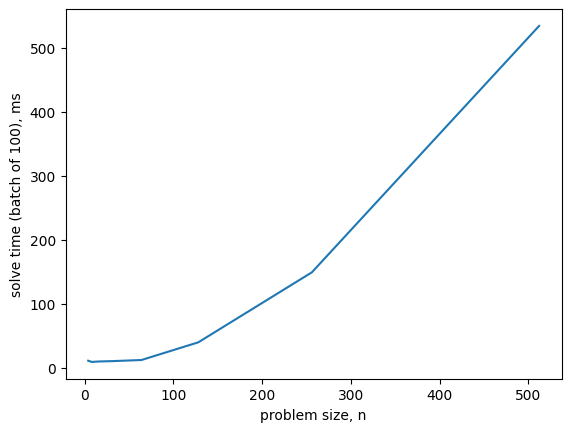

In [35]:
n_vals = [4, 8, 16, 32, 64, 128, 256, 512]
times = [10.9, 9.01, 9.7, 10.3, 12, 39.6, 149, 534]

from matplotlib import pyplot as plt

plt.plot(n_vals, times)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('problem size, n')
plt.ylabel('solve time (batch of 100), ms')

In [6]:
with jax.profiler.trace("/tmp/tensorboard"):
    prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
    sol_mine = jax.vmap(prob.solve)(data, state)

In [81]:
prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
sol_mine = jax.vmap(prob.solve)(data, state)

CPU times: user 31.9 ms, sys: 0 ns, total: 31.9 ms
Wall time: 31.6 ms


Text(0, 0.5, 'Freq')

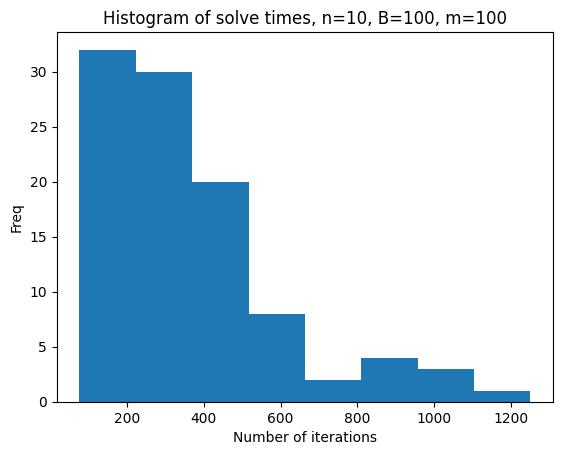

In [19]:
from matplotlib import pyplot as plt

plt.hist(sol[0], bins=8)
plt.title(f'Histogram of solve times, n={n}, B={B}, m={m}')
plt.xlabel('Number of iterations')
plt.ylabel('Freq')

In [162]:
A = sparse.random_bcoo(key, (5, 2, 2), nse=0.15, n_batch=1, generator=random.normal)
sum_x = jax.vmap(sparse.sparsify(lambda x: jnp.sum(x @ x.T + sparse.eye(2))))

sum_x(A)

Array([2.005999 , 2.1144671, 2.004582 , 2.5526845, 2.1723697], dtype=float32)

In [58]:
import jax_dataclasses as jdc

@jdc.pytree_dataclass
class Foo:
    x: jnp.ndarray
    y: jnp.ndarray
    z: jdc.Static[int]
    
def sumup(foo):
    return foo.x + foo.y

bar = Foo(jnp.ones((2, 5)), jnp.ones((2, 5)), 3)
jax.vmap(sumup)(bar)

Array([[2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2.]], dtype=float32)

In [108]:
A_sparse = sparse.random_bcoo(subkey, (B, m, n), nse=0.01, n_batch=1, generator=random.normal)
A = A_sparse.todense()

# Define jit'd matrix-vector product (vmap across batch dim)
bmm = jax.jit(jax.vmap(sparse.sparsify(lambda A, x: A @ x)))

# Run it once to compile
bmm(A, state.x)
bmm(A_sparse, state.x)

# Time dense / sparse naive calls
%timeit bmm(A, state.x) # 23.1 µs ± 1.59 µs per loop
%timeit bmm(A_sparse, state.x) # 32.6 µs ± 2.2 µs per loop

# jit a low-level matmul
bmm_sp = lambda A, x: sparse.bcoo_dot_general(A, x, dimension_numbers=((2, 1), (0,0)))
jitbmmsp = jax.jit(bmm_sp) 

jitbmmsp(A_sparse, state.x) # Run to compile
%timeit jitbmmsp(A_sparse, state.x) # 30.1 µs ± 2.02 µs per loop

23.8 µs ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
33.9 µs ± 2.21 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
32.5 µs ± 4.73 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [109]:
A_sparse.shape

(10, 1000, 100)

In [13]:
times

array([1.01929e-04, 7.16540e-05, 7.86100e-05, 6.80630e-05, 9.56100e-05,
       9.25430e-05, 7.00830e-05, 6.87880e-05, 6.65540e-05, 8.35460e-05,
       6.57870e-05, 7.05050e-05, 7.73720e-05, 7.14650e-05, 7.94590e-05,
       8.05140e-05, 6.83290e-05, 6.81150e-05, 1.06339e-04, 9.31520e-05,
       1.03047e-04, 6.90410e-05, 7.46700e-05, 7.05510e-05, 7.41210e-05,
       8.00460e-05, 7.63870e-05, 7.66250e-05, 6.33870e-05, 7.74470e-05,
       8.10120e-05, 8.12730e-05, 6.42190e-05, 7.13140e-05, 7.96050e-05,
       9.04820e-05, 6.59400e-05, 7.44840e-05, 6.54090e-05, 7.52960e-05,
       7.10590e-05, 6.42580e-05, 7.37630e-05, 6.42690e-05, 8.82850e-05,
       8.09510e-05, 7.42440e-05, 6.19750e-05, 6.32800e-05, 7.31040e-05,
       7.03010e-05, 7.92550e-05, 8.65800e-05, 7.18260e-05, 1.01640e-04,
       9.17890e-05, 6.83050e-05, 9.22900e-05, 1.17538e-04, 7.02920e-05,
       7.12120e-05, 9.51680e-05, 6.82410e-05, 7.57100e-05, 1.05142e-04,
       7.49970e-05, 7.89310e-05, 8.98780e-05, 7.31170e-05, 8.993

In [47]:
import osqp as oo
import numpy as np
import scipy 

results = []

def solve_all(results):
    solve_time = 0.
    for ii in range(B):
        m = oo.OSQP()
        m.setup(P=scipy.sparse.csc_matrix(np.asarray(P[ii, :, :])), q=np.asarray(q[ii,:]), A=scipy.sparse.csc_matrix(np.asarray(A[ii, :, :])), l=np.asarray(l[ii, :]), u=np.asarray(u[ii,:]), verbose=False)
        results.append(m.solve())
        solve_time += results[-1].info.setup_time + results[-1].info.solve_time
        
    return solve_time

solve_time = solve_all(results)

1000 * solve_time

85.22137500000001

In [48]:
osqp_iters = [rr.info.iter for rr in results]

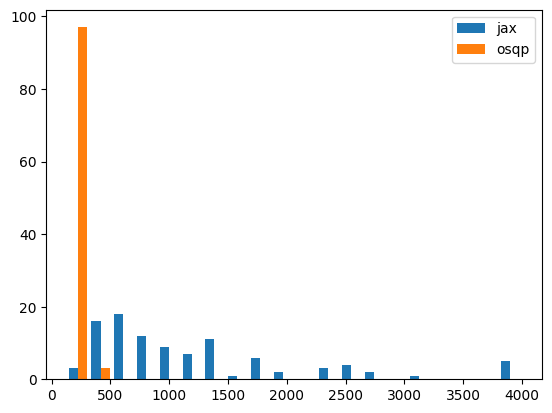

In [50]:
plt.close("all")
fig, ax = plt.subplots()
ax.hist([sol[0], osqp_iters], label=['jax', 'osqp'], bins=20)
# ax.hist(, bins=10, range=(0, max(sol[0])), label='osqp', alpha=0.5)
ax.legend()

In [39]:
from jaxopt import BoxOSQP

qp = BoxOSQP(jit=True)
solve_qp = jax.jit(jax.vmap(lambda P, q, A, l, u: qp.run(params_obj=(P, q), params_eq=A, params_ineq=(l,u)).params))

sol = solve_qp(P, q, A, l, u)
%timeit sol = solve_qp(P, q, A, l, u)

sol_mine[-1].x - sol.primal[0]

3.34 s ± 81.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NameError: name 'sol_mine' is not defined

In [44]:
osqp_iters = jnp.array(osqp_iters)
my_iters = sol[0]

print(f"osqp stats | mean: {jnp.mean(osqp_iters)}, median: {jnp.median(osqp_iters)}, std: {jnp.std(osqp_iters)}, max: {jnp.max(osqp_iters)}")
print(f"my stats | mean: {jnp.mean(my_iters)}, median: {jnp.median(my_iters)}, std: {jnp.std(my_iters)}, max: {jnp.max(my_iters)}")

osqp stats | mean: 97.5, median: 100.0, std: 28.173568725585938, max: 225
my stats | mean: 269.25, median: 238.5, std: 119.94034576416016, max: 701
